# ADS 509 Team 1 Project - Tesla vs Toyota News Articles
### By: Jesse Gutierrez, Roger Qiu, Shailja Somani
ADS-509: Applied Text Mining\
University of San Diego\
Summer 2024 

Project Title: Analyzing and Classifying News Articles as about Tesla or Toyota based on the Article Headline and Brief Description  

Link for API we are Using: https://newsapi.org/ \
newsapi Key: d6995599193044b0a5f954c098da84d6

## Part 1. API retrival, Data Pre-processing (Tokenization) and EDA

### Install and add imports

In [125]:
# Please install any below packages you may not have already installed and then restart the kernel
!pip install newsapi-python
!pip install textblob
!pip install xgboost
!pip install imblearn
!pip install pyLDAvis==3.4.1 --user
!pip install contractions

In [126]:
# Check Python version to ensure pyLDAvis package will work
import sys
sys.version

'3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:48) [Clang 13.0.0 (clang-1300.0.29.30)]'

In [127]:
from newsapi import NewsApiClient
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
import regex as re
from datetime import datetime, timedelta
import nltk
from string import punctuation
from contractions import fix
from textblob import TextBlob
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
nltk.download('stopwords')
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import Counter, defaultdict
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
#from wordcloud import WordCloud
#import seaborn as sns
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models
from tqdm.auto import tqdm

# Set display options to avoid truncation
pd.set_option('display.max_colwidth', None)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [128]:
# Hide warnings for cleanliness before knitting to PDF
import warnings
warnings.filterwarnings('ignore')

### Check the newsAPI data source

In [129]:
# use API key to initialize newsapi client
newsapi = NewsApiClient(api_key='d6995599193044b0a5f954c098da84d6')
newsapi

In [130]:
# check what the top headlines data looks like
top_headlines = newsapi.get_top_headlines(q='world',
                                          category='business',
                                          language='en',
                                          country='us')

top_headlines

{'status': 'ok',
 'totalResults': 2,
 'articles': [{'source': {'id': 'bloomberg', 'name': 'Bloomberg'},
   'author': 'Todd Gillespie',
   'title': 'Citigroup (C) Pitches Money-Moving Services Business as Central to Revamp - Bloomberg',
   'description': 'Citigroup Inc. is putting one of its least glamorous businesses front and center in its upgrade project, aiming to show how a sprawling system of moving money around the world can boost profitability.',
   'url': 'https://www.bloomberg.com/news/articles/2024-06-17/citi-pitches-money-moving-crown-jewel-as-central-to-revamp',
   'urlToImage': 'https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iDEd7WdV0Emw/v1/1200x801.jpg',
   'publishedAt': '2024-06-17T20:29:59Z',
   'content': 'Citigroup Inc. is putting one of its least glamorous businesses front and center in its upgrade project, aiming to show how a sprawling system of moving money around the world can boost profitability… [+413 chars]'},
  {'source': {'id': None, 'name': 'Tipranks.com

In [131]:
# check all the available news sources
sources = newsapi.get_sources()

# check first 3
sources['sources'][:3]

[{'id': 'abc-news',
  'name': 'ABC News',
  'description': 'Your trusted source for breaking news, analysis, exclusive interviews, headlines, and videos at ABCNews.com.',
  'url': 'https://abcnews.go.com',
  'category': 'general',
  'language': 'en',
  'country': 'us'},
 {'id': 'abc-news-au',
  'name': 'ABC News (AU)',
  'description': "Australia's most trusted source of local, national and world news. Comprehensive, independent, in-depth analysis, the latest business, sport, weather and more.",
  'url': 'https://www.abc.net.au/news',
  'category': 'general',
  'language': 'en',
  'country': 'au'},
 {'id': 'aftenposten',
  'name': 'Aftenposten',
  'description': 'Norges ledende nettavis med alltid oppdaterte nyheter innenfor innenriks, utenriks, sport og kultur.',
  'url': 'https://www.aftenposten.no',
  'category': 'general',
  'language': 'no',
  'country': 'no'}]

### Retrieve and download Toyota and Tesla related articles

In [132]:
# Please feel free to delete, but this elimates the need to update the date
# This is helpful as we can only pull data from w/in 29 days

# Get today's date
today = datetime.today()

# Calculate date 29 days ago
twentynine_days_ago = today - timedelta(days=29)

# Format dates in the required format (YYYY-MM-DD)
from_date = twentynine_days_ago.strftime('%Y-%m-%d')
to_date = today.strftime('%Y-%m-%d')

# Get Toyota news text data
toyota_raw = newsapi.get_everything(
    q='toyota',
    from_param=from_date,
    to=to_date,
    language='en',
    sort_by='relevancy',
    page=5
)

# Display the first 3 articles
toyota_articles = toyota_raw['articles'][:3]
for article in toyota_articles:
    print(article['title'], article['description'])

Toyota set to end massive Olympic sponsorship deal; unhappy over how IOC spent funds: report Vehicle manufacturer Toyota is set to end its massive sponsorship deal with the International Olympic Committee after this year's Paris Olympics, according to reports in Japan. Toyota has a contract through the 2024 Paris Games, which was reported to be value…
2025 Rivian R1S and R1T, 2026 Toyota GR GT3: This Week's Top Photos U.S. EV startup Rivian introduced a major update to its debut R1S SUV and R1T pickup truck, and we've already tested it. While the electric SUV and pickup truck may look the same on the outside, big changes have taken place beneath the sheet metal, including …
Flat 4-rotor hybrid? No, but Toyota, Subaru, and Mazda will develop a new engine together Toyota, Mazda, and Subaru on Tuesday announced plans for joint engine development aimed at reducing emissions. The goal of the project is to achieve carbon neutrality with internal-combustion engines, allowing these engines to 

In [133]:
# convert the json into a df
df = pd.DataFrame(toyota_raw['articles'])
df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Japan Today'}",None,Toyota set to end massive Olympic sponsorship deal; unhappy over how IOC spent funds: report,"Vehicle manufacturer Toyota is set to end its massive sponsorship deal with the International Olympic Committee after this year's Paris Olympics, according to reports in Japan. Toyota has a contract through the 2024 Paris Games, which was reported to be value…",https://japantoday.com/category/sports/report-japanese-carmaker-toyota-set-to-end-massive-olympic-sponsorship-deal,None,2024-05-27T21:45:55Z,"Vehicle manufacturer Toyota is set to end its massive sponsorship deal with the International Olympic Committee after this year's Paris Olympics, according to reports in Japan.\r\nToyota has a contract… [+3041 chars]"
1,"{'id': None, 'name': 'Motor Authority'}","news@motorauthority.com (Viknesh Vijayenthiran), Viknesh Vijayenthiran","2025 Rivian R1S and R1T, 2026 Toyota GR GT3: This Week's Top Photos","U.S. EV startup Rivian introduced a major update to its debut R1S SUV and R1T pickup truck, and we've already tested it. While the electric SUV and pickup truck may look the same on the outside, big changes have taken place beneath the sheet metal, including …",https://www.motorauthority.com/news/1143444_2025-rivian-r1-2026-toyota-gr-gt3-this-week-s-top-photos,https://images.hgmsites.net/hug/rivian_100932073_h.jpg,2024-06-08T14:00:00Z,"U.S. EV startup Rivian introduced a major update to its debut R1S SUV and R1T pickup truck, and we've already tested it. While the electric SUV and pickup truck may look the same on the outside, big … [+2042 chars]"
2,"{'id': None, 'name': 'Motor Authority'}","news@motorauthority.com (Stephen Edelstein), Stephen Edelstein","Flat 4-rotor hybrid? No, but Toyota, Subaru, and Mazda will develop a new engine together","Toyota, Mazda, and Subaru on Tuesday announced plans for joint engine development aimed at reducing emissions. The goal of the project is to achieve carbon neutrality with internal-combustion engines, allowing these engines to stay in production in a future o…",https://www.motorauthority.com/news/1143295_flat-4-rotor-hybrid-no-but-toyota-subaru-and-mazda-will-develop-a-new-engine-together,https://images.hgmsites.net/hug/toyota-1-5-liter-inline-4_100930748_h.jpg,2024-05-28T15:07:00Z,"Toyota, Mazda, and Subaru on Tuesday announced plans for joint engine development aimed at reducing emissions.\r\nThe goal of the project is to achieve carbon neutrality with internal-combustion engine… [+1672 chars]"
3,"{'id': None, 'name': 'IndieWire'}",Tony Maglio,Mid-Movie Ads Could Be Coming to a Streaming Service Near You,"Ads on streaming have been around for a bit, but are they coming for at-home movie releases? IndieWire talks to advertising and AI experts.",https://www.indiewire.com/news/analysis/streaming-ads-movie-releases-netflix-warner-bros-1235006272/,https://www.indiewire.com/wp-content/uploads/2024/05/WBD_UPFRONT_24_25_0012.jpg?w=650,2024-05-23T13:00:00Z,"Last week, Amazon made its first-ever pitch to advertisers at the annual upfronts in New York; for Netflix, it was the first it’s done in person. The streamers also pitched a whole new kind of TV sho… [+4448 chars]"
4,"{'id': None, 'name': 'The Boston Globe'}",YURI KAGEYAMA,Toyota apologizes for cheating on vehicle testing and halts production of three models,"The wide-ranging fraudulent testing at Japan’s top automaker involved the use of inadequate or outdated data in collision tests, and incorrect testing of airbag inflation and rear-seat damage in crashes.",https://www.bostonglobe.com/2024/06/03/business/toyota-apologizes-cheating-vehicle-testing-halts-production-three-models/,https://bostonglobe-prod.cdn.arcpublishing.com/resizer/ABdGYDUxRco-u31KonPp-7G-fIQ=/506x0/cloudfront-us-east-1.images.arcpublishing.com/bostonglobe/ABBDJUDR3HWRIIP4YXPAB2LQUA.jpg,2024-06-03T22:06:30Z,TOKYO (AP) Toyota chairman Akio Toyoda apologized Monday for massi

In [134]:
# create a data folder to store the csv data
if not os.path.exists('data/toyota'):
    os.makedirs('data/toyota')

In [135]:
# download the toyota text data to data folder
df.to_csv('data/toyota/data.csv', index=False)

In [136]:
# Please feel free to delete, but this elimates the need to update the date
# This is helpful as we can only pull data from w/in 29 days

# Get today's date
today = datetime.today()

# Format dates in the required format (YYYY-MM-DD)
from_date = twentynine_days_ago.strftime('%Y-%m-%d')
to_date = today.strftime('%Y-%m-%d')

# Get Toyota news text data
tesla_raw = newsapi.get_everything(
    q='tesla',
    from_param=from_date,
    to=to_date,
    language='en',
    sort_by='relevancy',
    page=5
)

# Display the first 3 articles
tesla_articles = tesla_raw['articles'][:3]
for article in tesla_articles:
    print(article['title'], article['description'])

Is It Time to Buy 3 of the S&P 500's Worst-Performing Stocks of 2024? The S&P 500 includes some of the best companies in the world. Among the worst performers in the index this year are industry-leading businesses that could be undervalued. While the index is up 11% year to date, shares of Intel (NASDAQ: INTC), Starbucks (NASDA…
Shareholders show how much Elon Musk means to Tesla Shareholders show how much Elon Musk means to Tesla Axios
Opinion | Tesla's shareholders approved $50 billion for Musk, picking hype over reality - The Washington Post The Washington Post
It’s payday for Elon Musk: Jack Otter Fox Business
Elon Musk wins Tesla…
Elon Musk's pay package approval was a mistake and Tesla needs to keep him in check, some institutional shareholders say Elon Musk.
Apu Gomes via Getty Images
Tesla investors voted on Thursday to approve Elon Musk's multibillion-dollar pay package.
However, some institutional shareholders told BI that Musk's award was a mistake.
One investor questioned i

### Read in Tesla & Toyota CSVs just saved and do Initial Transformations
We use CSVs from the initial API pull to make our project repeatable and easier to collaborate on.

In [137]:
# For whatever reason, this did not work for me even though I can see the file in the directory

# read in the data
#raw_tesla = pd.read_csv('data/tesla/data.csv')
#raw_tesla.head()

# I had to use this approach
raw_tesla = pd.read_csv('/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Project 2.0/ADS-509-Team-1/data/tesla/data.csv')
raw_tesla.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]"
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]"
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model … [+6014 chars]
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In The Q1 2024 Earnings Call,"The Tesla, Inc. Q1 2024 earnings call was fascinating in how Tesla representatives drew on carefully phrased statements to appease and turn around what was then a largely disgruntled shareholder group. The revisionist language within the earnings call took co…",https://cleantechnica.com/2024/04/26/the-revisionist-language-that-tesla-used-in-the-q1-2024-earnings-call/,https://cleantechnica.com/wp-content/uploads/2023/06/Elon-Musk-CleanTechnica-shirt-Tesla-Model-Y-reveal-watermark.jpeg,2024-04-26T19:24:10Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nThe Tesla, Inc. Q1 2024 earnings call was fascinating in how Tesla representatives drew on carefully phrased … [+9089 chars]"
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M to ease access to AI compute,"A French startup has raised a hefty seed investment to ""rearchitect compute infrastructure"" for developers wanting to build and train AI applications more...",https://techcrunch.com/2024/04/23/french-startup-flexai-exits-stealth-with-30m-to-ease

In [138]:
# 100 records with 8 fields
raw_tesla.shape

(100, 8)

In [139]:
# read the CSV file again
raw_toyota = pd.read_csv('data/toyota/data.csv')
raw_toyota.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Japan Today'}",NaN,Toyota set to end massive Olympic sponsorship deal; unhappy over how IOC spent funds: report,"Vehicle manufacturer Toyota is set to end its massive sponsorship deal with the International Olympic Committee after this year's Paris Olympics, according to reports in Japan. Toyota has a contract through the 2024 Paris Games, which was reported to be value…",https://japantoday.com/category/sports/report-japanese-carmaker-toyota-set-to-end-massive-olympic-sponsorship-deal,NaN,2024-05-27T21:45:55Z,"Vehicle manufacturer Toyota is set to end its massive sponsorship deal with the International Olympic Committee after this year's Paris Olympics, according to reports in Japan.\r\nToyota has a contract… [+3041 chars]"
1,"{'id': None, 'name': 'Motor Authority'}","news@motorauthority.com (Viknesh Vijayenthiran), Viknesh Vijayenthiran","2025 Rivian R1S and R1T, 2026 Toyota GR GT3: This Week's Top Photos","U.S. EV startup Rivian introduced a major update to its debut R1S SUV and R1T pickup truck, and we've already tested it. While the electric SUV and pickup truck may look the same on the outside, big changes have taken place beneath the sheet metal, including …",https://www.motorauthority.com/news/1143444_2025-rivian-r1-2026-toyota-gr-gt3-this-week-s-top-photos,https://images.hgmsites.net/hug/rivian_100932073_h.jpg,2024-06-08T14:00:00Z,"U.S. EV startup Rivian introduced a major update to its debut R1S SUV and R1T pickup truck, and we've already tested it. While the electric SUV and pickup truck may look the same on the outside, big … [+2042 chars]"
2,"{'id': None, 'name': 'Motor Authority'}","news@motorauthority.com (Stephen Edelstein), Stephen Edelstein","Flat 4-rotor hybrid? No, but Toyota, Subaru, and Mazda will develop a new engine together","Toyota, Mazda, and Subaru on Tuesday announced plans for joint engine development aimed at reducing emissions. The goal of the project is to achieve carbon neutrality with internal-combustion engines, allowing these engines to stay in production in a future o…",https://www.motorauthority.com/news/1143295_flat-4-rotor-hybrid-no-but-toyota-subaru-and-mazda-will-develop-a-new-engine-together,https://images.hgmsites.net/hug/toyota-1-5-liter-inline-4_100930748_h.jpg,2024-05-28T15:07:00Z,"Toyota, Mazda, and Subaru on Tuesday announced plans for joint engine development aimed at reducing emissions.\r\nThe goal of the project is to achieve carbon neutrality with internal-combustion engine… [+1672 chars]"
3,"{'id': None, 'name': 'IndieWire'}",Tony Maglio,Mid-Movie Ads Could Be Coming to a Streaming Service Near You,"Ads on streaming have been around for a bit, but are they coming for at-home movie releases? IndieWire talks to advertising and AI experts.",https://www.indiewire.com/news/analysis/streaming-ads-movie-releases-netflix-warner-bros-1235006272/,https://www.indiewire.com/wp-content/uploads/2024/05/WBD_UPFRONT_24_25_0012.jpg?w=650,2024-05-23T13:00:00Z,"Last week, Amazon made its first-ever pitch to advertisers at the annual upfronts in New York; for Netflix, it was the first it’s done in person. The streamers also pitched a whole new kind of TV sho… [+4448 chars]"
4,"{'id': None, 'name': 'The Boston Globe'}",YURI KAGEYAMA,Toyota apologizes for cheating on vehicle testing and halts production of three models,"The wide-ranging fraudulent testing at Japan’s top automaker involved the use of inadequate or outdated data in collision tests, and incorrect testing of airbag inflation and rear-seat damage in crashes.",https://www.bostonglobe.com/2024/06/03/business/toyota-apologizes-cheating-vehicle-testing-halts-production-three-models/,https://bostonglobe-prod.cdn.arcpublishing.com/resizer/ABdGYDUxRco-u31KonPp-7G-fIQ=/506x0/cloudfront-us-east-1.images.arcpublishing.com/bostonglobe/ABBDJUDR3HWRIIP4YXPAB2LQUA.jpg,2024-06-03T22:06:30Z,TOKYO (AP) Toyota chairman Akio Toyoda apologized Monday for massive

In [140]:
# also 100 records and 8 fields
raw_toyota.shape

(100, 8)

In [141]:
# check how the title looks
raw_tesla['title'][0]

'Tesla “Full Self Driving” Could Come To Other Countries Before Long'

In [142]:
# check how content looks
raw_tesla['content'][0]

'Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]'

In [143]:
# check how the description looks
raw_tesla['description'][0]

# descriptions gives more information than content field.
# so title and description are the 2 fields we can use to combine into a new "text" field.

'Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…'

In [144]:
# label both df's and then union into 1 df with 200 records
raw_tesla['label'] = 'tesla'
raw_toyota['label'] = 'toyota'

raw_tesla.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model … [+6014 chars],tesla
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In The Q1 2024 Earnings Call,"The Tesla, Inc. Q1 2024 earnings call was fascinating in how Tesla representatives drew on carefully phrased statements to appease and turn around what was then a largely disgruntled shareholder group. The revisionist language within the earnings call took co…",https://cleantechnica.com/2024/04/26/the-revisionist-language-that-tesla-used-in-the-q1-2024-earnings-call/,https://cleantechnica.com/wp-content/uploads/2023/06/Elon-Musk-CleanTechnica-shirt-Tesla-Model-Y-reveal-watermark.jpeg,2024-04-26T19:24:10Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nThe Tesla, Inc. Q1 2024 earnings call was fascinating in how Tesla representatives drew on carefully phrased … [+9089 chars]",tesla
4,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Paul Sawers,French startup FlexAI exits stealth with $30M to ease access to AI compute,"A French startup has raised a hefty seed investment to ""rearchitect compute infrastructure"" for developers wanting to build and train AI applications more...",https://techcrunch.com/2024/04/23/french-startup-flexai-

In [145]:
# union so both Tesla & Toyota data is in combined df
combined = pd.concat([raw_tesla, raw_toyota], axis=0, ignore_index=True)
combined.shape

(200, 9)

In [146]:
# concat title with description to create text field
combined['text'] = combined['title'] + ' ' + combined['description']
combined['text'][0]

'Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…'

In [147]:
# check another example
combined['text'][105]

"Vin Diesel Teased The Return Of Paul Walker's Iconic Car In Fast 11, And Fans Are Here For The Nostalgia The orange Toyota Supra Paul Walker drove in The Fast and the Furious was a highlight, and now Vin Diesel is teasing it will be back in Fast 11."

In [148]:
# add a length field to check text lengths
combined['length'] = combined['text'].str.len()
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model … [+6014 chars],tesla,"Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year! A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",333.0
3,"{'id': None, 'name': 'CleanTechnica'}",Carolyn Fortuna,The Revisionist Language That Tesla Used In The Q1 2024 Earnings Call,"The Tesla, Inc. Q1 2024 earnings call was

###

<Figure size 800x600 with 0 Axes>

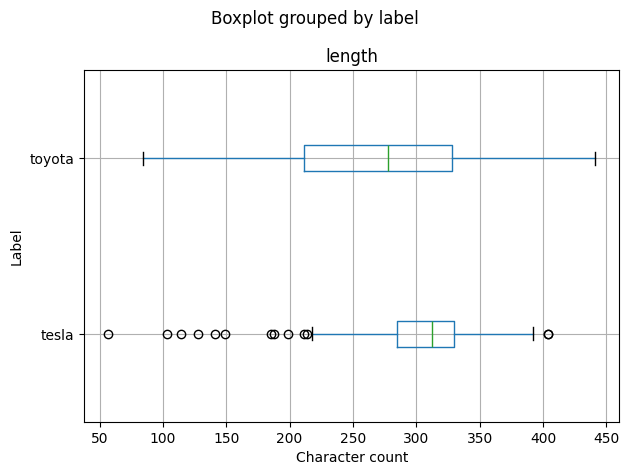

In [149]:
# create boxplot to see distribution of counts by label
plt.figure(figsize=(8, 6))
combined.boxplot(column='length', by='label', vert=False)
plt.xlabel('Character count')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

### Clean and Tokenize text

In [150]:
# define function to tokenize text
def tokenize(text):
  return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [151]:
# check stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
list(stopwords)[:5]

['t', "hadn't", 'more', 'ma', 'didn']

In [152]:
# add tesla and toyota as stopwords, we do not want to see these words in the features
include_stopwords = {'tesla', 'toyota'}
stopwords |= include_stopwords

In [153]:
# define function to remove stopwords
def remove_stop(tokens):
  return [t for t in tokens if t.lower() not in stopwords]

In [154]:
# define function to remove punctuation
def remove_punctuation(text):
  punct_set=set(punctuation)
  return("".join([ch for ch in text if ch not in punct_set]))

In [155]:
# define function to expand out contractions using contractions package
def expand_contractions(text):
  return fix(text)

In [156]:
# create pipeline to lowercase, remove punctuation, tokenize and remove stop words
pipeline = [str.lower, expand_contractions, remove_punctuation, tokenize, remove_stop]

# define function to feed text data through the pipeline and return cleaned tokens
def prepare(text, pipeline):

  # convert text to string if it's not already a string (for float types)
  text = str(text)

  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return tokens

In [157]:
combined['tokens'] = combined['text'].apply(prepare, pipeline=pipeline)
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]"
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0,"[many, model, sales, model, sales, usa, 1st, quarter, tough, quarter, including, united, states, tough, quarter, would, stunning, fantabulous, success, company, trying, sell, electric, vehicles, usa, according, data, cox, automotive, kelley, blue]"
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model … [+6014 chars],tesla,"Tesla Surprises

In [158]:
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]"


In [159]:
# get the number of tokens as a field
combined['num_tokens'] = combined['tokens'].map(len)
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]",32


In [160]:
# download the combined text data to data folder
combined.to_csv('data/combined.csv', index=False)

### EDA and visualizations

In [161]:
# Read back in if pulling from saved file - again, done for ease of collaboration & reproducability
combined = pd.read_csv('data/combined.csv')

In [162]:
# seperate records based on labels in 2 different series
tesla_tokens = combined.loc[combined['label'] == 'tesla', 'tokens']
toyota_tokens = combined.loc[combined['label'] == 'toyota', 'tokens']

tesla_tokens[:5]

0                            ['full', 'self', 'driving', 'could', 'come', 'countries', 'long', 'ever', 'since', 'started', 'rolling', 'full', 'self', 'driving', 'fsd', 'nonemployee', 'owners', 'us', 'people', 'countries', 'asking', 'able', 'install', 'use', 'fsd', 'far', 'remember', 'always', 'vague', 'someday', 'kind', 'resp']
1                   ['many', 'model', 'sales', 'model', 'sales', 'usa', '1st', 'quarter', 'tough', 'quarter', 'including', 'united', 'states', 'tough', 'quarter', 'would', 'stunning', 'fantabulous', 'success', 'company', 'trying', 'sell', 'electric', 'vehicles', 'usa', 'according', 'data', 'cox', 'automotive', 'kelley', 'blue']
2                                         ['surprises', 'investors', 'tiny', 'tiny', 'soon', 'year', 'lot', 'written', 'nextgeneration', 'compact', 'car', 'used', 'widely', 'called', 'model', 'including', 'zach', 'excellent', 'article', 'last', 'week', 'zach', 'asked', 'might', 'pick', 'challenge', 'place', 'today', 'announce']
3    ['rev

In [163]:
# flatten each so we can get all tokens in each df into a single list
tesla_flat_tokens = [word for sublist in tesla_tokens for word in sublist]
toyota_flat_tokens = [word for sublist in toyota_tokens for word in sublist]

tesla_flat_tokens[:5]

['[', "'", 'f', 'u', 'l']

In [164]:
# Had to adjust the previous codes to get it to run on my end
import ast

# Separate records based on labels into 2 different series
tesla_tokens = combined.loc[combined['label'] == 'tesla', 'tokens']
toyota_tokens = combined.loc[combined['label'] == 'toyota', 'tokens']

# Ensure tokens are lists
tesla_tokens = tesla_tokens.apply(ast.literal_eval)
toyota_tokens = toyota_tokens.apply(ast.literal_eval)

# Flatten each series so we can get all tokens into a single list
tesla_flat_tokens = [word for sublist in tesla_tokens for word in sublist]
toyota_flat_tokens = [word for sublist in toyota_tokens for word in sublist]

# Print the first few tokens to ensure they are correctly extracted
print(tesla_flat_tokens[:5])
print(toyota_flat_tokens[:5])

['full', 'self', 'driving', 'could', 'come']
['set', 'end', 'massive', 'olympic', 'sponsorship']


In [165]:
# 2828 tokens
len(tesla_flat_tokens)

2824

In [166]:
# get count of each word
tesla_word_counts = Counter(tesla_flat_tokens)
toyota_word_counts = Counter(toyota_flat_tokens)

# check the first 5 records
dict(list(tesla_word_counts.items())[:5])

{'full': 10, 'self': 3, 'driving': 3, 'could': 7, 'come': 3}

In [167]:
# get the 10 most common words for both each
print(tesla_word_counts.most_common(10))

[('musk', 30), ('elon', 29), ('ev', 24), ('model', 22), ('earnings', 21), ('company', 20), ('china', 19), ('electric', 18), ('cybertruck', 18), ('fsd', 16)]


In [168]:
print(toyota_word_counts.most_common(10))

[('car', 29), ('new', 28), ('motor', 25), ('vehicle', 21), ('chairman', 18), ('hybrid', 16), ('shareholders', 16), ('toyoda', 16), ('electric', 14), ('engines', 13)]


In [169]:
# convert counter type to list so we can plot
top_tesla_words = list(tesla_word_counts.most_common(10))
top_toyota_words = list(toyota_word_counts.most_common(10))

In [170]:
# get words and their count from the list
tesla_words, tesla_counts = zip(*top_tesla_words)
toyota_words, toyota_counts = zip(*top_toyota_words)

print(tesla_words)
print(tesla_counts)

('musk', 'elon', 'ev', 'model', 'earnings', 'company', 'china', 'electric', 'cybertruck', 'fsd')
(30, 29, 24, 22, 21, 20, 19, 18, 18, 16)


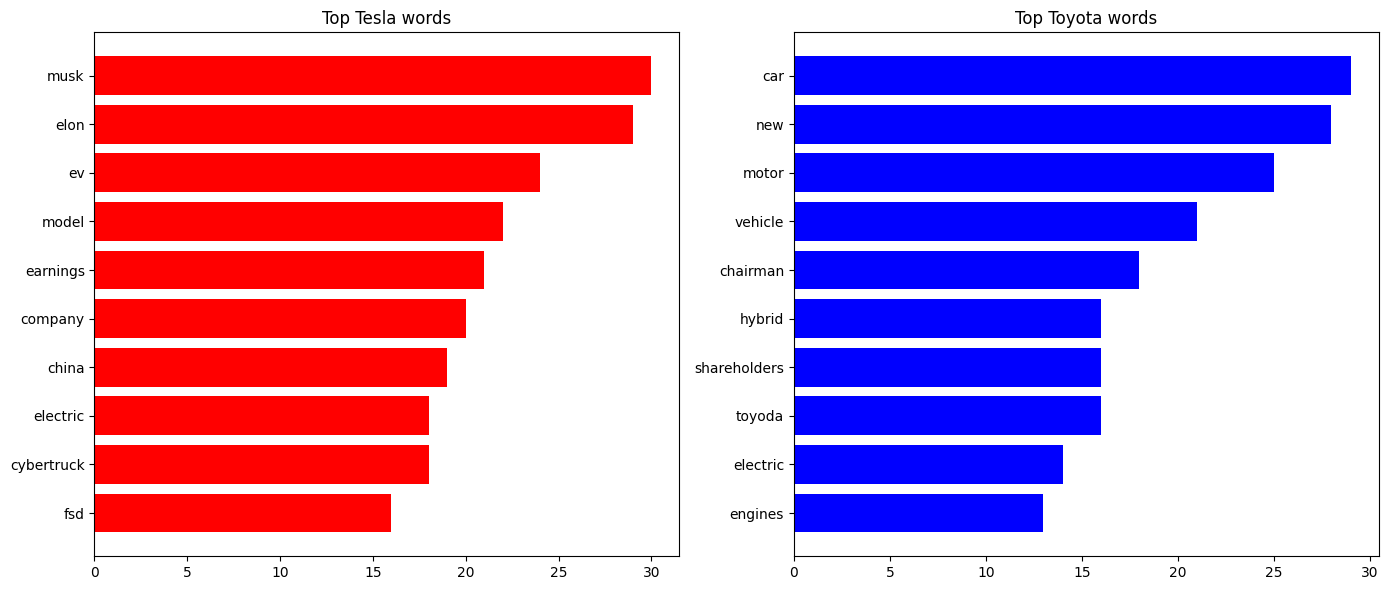

In [171]:
# create 2 subplots, next to eachother
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# plot tesla words, highest counts at the top
ax[0].barh(tesla_words, tesla_counts, color='red')
ax[0].invert_yaxis()
ax[0].set_title('Top Tesla words')

# do the same for toyota
ax[1].barh(toyota_words, toyota_counts, color='blue')
ax[1].invert_yaxis()  # Highest counts at the top
ax[1].set_title('Top Toyota words')

# show the plot, tight layout so fit is better
plt.tight_layout()
plt.show()

In [172]:
# now to get the descriptive statistics, define the function created in earlier assignments
def descriptive_stats(tokens, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity),
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters.

    """

    # length of num tokens list
    num_tokens = len(tokens)

    # length of unique tokens in list
    num_unique_tokens = len(set(tokens))

    # unique tokens divided by total tokens to see diversity
    lexical_diversity = num_unique_tokens / num_tokens

    # get sum of characters
    sum = 0
    for word in tokens:
        for char in word:
            sum += 1

    num_characters = sum

    if verbose :
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [173]:
# Split the DataFrame based on the "label" field
tesla_df = combined[combined['label'] == 'tesla']
toyota_df = combined[combined['label'] == 'toyota']

# Combine all the lists in the "tokens" field into one giant list for each DataFrame
tesla_tokens = [item for sublist in tesla_df['tokens'] for item in sublist]
toyota_tokens = [item for sublist in toyota_df['tokens'] for item in sublist]

In [174]:
# That previous code did not work as it splits the words into letters

# Separate records based on labels into 2 different series
tesla_tokens = combined.loc[combined['label'] == 'tesla', 'tokens']
toyota_tokens = combined.loc[combined['label'] == 'toyota', 'tokens']

# Ensure tokens are lists
tesla_tokens = tesla_tokens.apply(ast.literal_eval)
toyota_tokens = toyota_tokens.apply(ast.literal_eval)

# Flatten each series so we can get all tokens into a single list
tesla_flat_tokens = [word for sublist in tesla_tokens for word in sublist]
toyota_flat_tokens = [word for sublist in toyota_tokens for word in sublist]

In [175]:
tesla_tokens[:5]

0                                [full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]
1                     [many, model, sales, model, sales, usa, 1st, quarter, tough, quarter, including, united, states, tough, quarter, would, stunning, fantabulous, success, company, trying, sell, electric, vehicles, usa, according, data, cox, automotive, kelley, blue]
2                                       [surprises, investors, tiny, tiny, soon, year, lot, written, nextgeneration, compact, car, used, widely, called, model, including, zach, excellent, article, last, week, zach, asked, might, pick, challenge, place, today, announce]
3    [revisionist, language, used, q1, earnings, call, inc, q1, earnings, call, fascinating, representatives, drew, carefully, phrased, statements, appease, turn, around, largely, disgruntle

In [176]:
# I had to adjust the above code to tokenize the vectors into words and not letters

import ast

# Split the DataFrame based on the "label" field
tesla_df = combined[combined['label'] == 'tesla']
toyota_df = combined[combined['label'] == 'toyota']

# Ensure tokens are lists
tesla_df['tokens'] = tesla_df['tokens'].apply(ast.literal_eval)
toyota_df['tokens'] = toyota_df['tokens'].apply(ast.literal_eval)

# Combine all the lists in the "tokens" field into one giant list for each DataFrame
tesla_tokens = [item for sublist in tesla_df['tokens'] for item in sublist]
toyota_tokens = [item for sublist in toyota_df['tokens'] for item in sublist]

# Print the first few tokens to ensure they are correctly extracted
print(tesla_tokens[:5])
print(toyota_tokens[:5])


['full', 'self', 'driving', 'could', 'come']
['set', 'end', 'massive', 'olympic', 'sponsorship']


In [177]:
# apply descriptive stats to the tesla tokens
descriptive_stats(tesla_tokens)

There are 2824 tokens in the data.
There are 1430 unique tokens in the data.
There are 17429 characters in the data.
The lexical diversity is 0.506 in the data.


[2824, 1430, 0.5063739376770539, 17429]

In [178]:
# do the same for toyota
descriptive_stats(toyota_tokens)

There are 2647 tokens in the data.
There are 1389 unique tokens in the data.
There are 16511 characters in the data.
The lexical diversity is 0.525 in the data.


[2647, 1389, 0.5247449943332074, 16511]

## Part 2: Sentiment Analysis & Classification Models

In [179]:
# read in the data if starting from this cell
combined = pd.read_csv('data/combined.csv')
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"['full', 'self', 'driving', 'could', 'come', 'countries', 'long', 'ever', 'since', 'started', 'rolling', 'full', 'self', 'driving', 'fsd', 'nonemployee', 'owners', 'us', 'people', 'countries', 'asking', 'able', 'install', 'use', 'fsd', 'far', 'remember', 'always', 'vague', 'someday', 'kind', 'resp']",32
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0,"['many', 'model', 'sales', 'model', 'sales', 'usa', '1st', 'quarter', 'tough', 'quarter', 'including', 'united', 'states', 'tough', 'quarter', 'would', 'stunning', 'fantabulous', 'success', 'company', 'trying', 'sell', 'electric', 'vehicles', 'usa', 'according', 'data', 'cox', 'automotive', 'kelley', 'blue']",31
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lo

In [180]:
# Sentiment analysis and certain vectorizers require a string column
# Thus, let's convert our cleaned tokens back to a string
# Map all items to str in case some #s are within the tokens
combined['clean_tokens_str'] = combined['tokens'].apply(lambda x: ' '.join(map(str, x)))
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens,clean_tokens_str
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"['full', 'self', 'driving', 'could', 'come', 'countries', 'long', 'ever', 'since', 'started', 'rolling', 'full', 'self', 'driving', 'fsd', 'nonemployee', 'owners', 'us', 'people', 'countries', 'asking', 'able', 'install', 'use', 'fsd', 'far', 'remember', 'always', 'vague', 'someday', 'kind', 'resp']",32,"[ ' f u l l ' , ' s e l f ' , ' d r i v i n g ' , ' c o u l d ' , ' c o m e ' , ' c o u n t r i e s ' , ' l o n g ' , ' e v e r ' , ' s i n c e ' , ' s t a r t e d ' , ' r o l l i n g ' , ' f u l l ' , ' s e l f ' , ' d r i v i n g ' , ' f s d ' , ' n o n e m p l o y e e ' , ' o w n e r s ' , ' u s ' , ' p e o p l e ' , ' c o u n t r i e s ' , ' a s k i n g ' , ' a b l e ' , ' i n s t a l l ' , ' u s e ' , ' f s d ' , ' f a r ' , ' r e m e m b e r ' , ' a l w a y s ' , ' v a g u e ' , ' s o m e d a y ' , ' k i n d ' , ' r e s p ' ]"
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0,"['many', 'model', 'sales', 'model', 'sales', 'usa', '1st', 'quarter', 'tough', 'quarter', 'including', 'united', 'states', 'tough', 'quarter', 'would', 'stunning', 'fantabulous', 'success', 'company', 'trying', 'sell', 'electric', 'vehicles', 'usa', 'according', 'data', 'cox', 'automotive', 'kelley', 'blue']",31,"[ ' m a n y ' , ' m o d e l ' , ' s a l e s ' , ' m o d e l ' , ' s a l e s ' , ' u s a ' , ' 1 s t ' , ' q u a r t e r ' , ' t o u g h ' , ' q u a r t e r ' , ' i n c l u d i n g ' , ' 

In [181]:
# As you can see above the clean_token_str came out odd on my end so I had to adjust the following code to get it to work
# Read in the data
combined = pd.read_csv('data/combined.csv')

# Ensure tokens are lists
combined['tokens'] = combined['tokens'].apply(ast.literal_eval)

# Display the first few rows to verify
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]",32
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0,"[many, model, sales, model, sales, usa, 1st, quarter, tough, quarter, including, united, states, tough, quarter, would, stunning, fantabulous, success, company, trying, sell, electric, vehicles, usa, according, data, cox, automotive, kelley, blue]",31
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantechnica.com/2024/04/23/tesla-surprises-investors-with-a-tiny-y-a-tiny-3-as-soon-as-this-year/,https://cleantechnica.com/wp-content/uploads/2023/12/Apple-Car-Tesla-Model-3-CleanTechnica-Front-Glass-Watermark-Logo-scaled.jpeg,2024-04-24T01:56:23Z,Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nA lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model … [+6014 chars],tesla

In [182]:
# Convert the list of tokens back to a single string
combined['clean_tokens_str'] = combined['tokens'].apply(lambda x: ' '.join(map(str, x)))

# Display the first few rows to verify
print(combined[['tokens', 'clean_tokens_str']].head())

                                                                                                                                                                                                                                                                     tokens  \
0                              [full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]   
1                   [many, model, sales, model, sales, usa, 1st, quarter, tough, quarter, including, united, states, tough, quarter, would, stunning, fantabulous, success, company, trying, sell, electric, vehicles, usa, according, data, cox, automotive, kelley, blue]   
2                                     [surprises, investors, tiny, tiny, soon, year, lot, written, nextgeneration, compact, car, used, widely, called, model, including, zach, excellent, a

In [183]:
# First want to create a sentiment analyzes between the two automanufacturers

# Define a function to handle sentiment analysis, with a check for non-string values
# use textblob and sentiment attribute to return the polarity score which ranges from -1 to 1 for negative or positive sentiment
def analyze_sentiment(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    else:
        return None

# Apply the sentiment analysis function, handling non-string values
combined['sentiment'] = combined['clean_tokens_str'].apply(analyze_sentiment)

In [184]:
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens,clean_tokens_str,sentiment
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]",32,full self driving could come countries long ever since started rolling full self driving fsd nonemployee owners us people countries asking able install use fsd far remember always vague someday kind resp,0.192857
1,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter,"Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",https://cleantechnica.com/2024/04/19/more-than-3x-as-many-tesla-model-y-sales-as-tesla-model-3-sales-in-usa-in-1st-quarter/,https://cleantechnica.com/wp-content/uploads/2024/02/New-Tesla-Model-Y-Model-3-Model-S-Model-X-Supercharging-Florida-Station-CleanTechnica-Watermark-Sky-logo-800x445.png,2024-04-20T03:57:24Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nTesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a st… [+4173 chars]",tesla,"More Than 3× As Many Tesla Model Y Sales As Tesla Model 3 Sales In USA In 1st Quarter Tesla’s just had a tough quarter, including in the United States, but a tough quarter for Tesla would be a stunning, fantabulous success for any other company trying to sell electric vehicles. In the USA, according to data from Cox Automotive and Kelley Blue …",346.0,"[many, model, sales, model, sales, usa, 1st, quarter, tough, quarter, including, united, states, tough, quarter, would, stunning, fantabulous, success, company, trying, sell, electric, vehicles, usa, according, data, cox, automotive, kelley, blue]",31,many model sales model sales usa 1st quarter tough quarter including united states tough quarter would stunning fantabulous success company trying sell electric vehicles usa according data cox automotive kelley blue,0.087037
2,"{'id': None, 'name': 'CleanTechnica'}",Paul Fosse,Tesla Surprises Investors With A Tiny Y & A Tiny 3 As Soon As This Year!,"A lot has been written about the Tesla’s next-generation compact car that used to be widely called the Model 2, including Zach’s excellent article last week about it. Zach asked who might pick up the challenge in place of Tesla doing it. Today, Tesla announce…",https://cleantec

In [185]:
# Find the record with the highest sentiment value and select specific columns
highest_sentiment_record = combined.loc[combined['sentiment'].idxmax(), ['tokens', 'sentiment']]

# Find the record with the lowest sentiment value and select specific columns
lowest_sentiment_record = combined.loc[combined['sentiment'].idxmin(), ['tokens', 'sentiment']]

# check the most positive
highest_sentiment_record

tokens       [unlock, best, ux, design, avoid, blunders, could, tank, drive, tale, two, ux, designs, one, cars, model, needs, work, continue, reading]
sentiment                                                                                                                                          1.0
Name: 113, dtype: object

In [186]:
# check the most negative
lowest_sentiment_record

tokens       [cowards, hated, supra, bmw, components, dying, report, a90, supra, finally, hit, scene, production, vehicle, detractors, immediately, crawled, woodwork, hate, sharing, bmw, platform, never, mind, laid, specs, chassis, never, mind, engineers, japan]
sentiment                                                                                                                                                                                                                                                    -0.566667
Name: 150, dtype: object

In [187]:
# filter on either tesla or toyota to split dataset
tesla_df = combined[combined["label"] == "tesla"]
toyota_df = combined[combined["label"] == "toyota"]

In [188]:
print(tesla_df.shape)
print(toyota_df.shape)

(100, 15)
(100, 15)


In [189]:
# Function to calculate statistics for the sentiment
def calculate_stats(df):
    valid_sentiments = df['sentiment'].dropna()
    sentiment_range = valid_sentiments.max() - valid_sentiments.min()
    sentiment_min = valid_sentiments.min()
    sentiment_max = valid_sentiments.max()
    sentiment_median = valid_sentiments.median()
    sentiment_mean = valid_sentiments.mean()
    return sentiment_range, sentiment_min, sentiment_max, sentiment_median, sentiment_mean

# Calculate stats for Tesla
tesla_range, tesla_min, tesla_max, tesla_median, tesla_mean = calculate_stats(tesla_df)
# Calculate stats for Toyota
toyota_range, toyota_min, toyota_max, toyota_median, toyota_mean = calculate_stats(toyota_df)

# Display the results
print("Tesla DataFrame:")
tesla_df
print(f" Sentiment Median: {tesla_median}, Range: {tesla_range},  Min: {tesla_min}, Max: {tesla_max},  Mean: {tesla_mean}")

print("\nToyota DataFrame:")
toyota_df
print(f" Sentiment Median: {toyota_median}, Range: {toyota_range},  Min: {toyota_min}, Max: {toyota_max},  Mean: {toyota_mean}")

Tesla DataFrame:
 Sentiment Median: 0.061541125541125535, Range: 1.2000000000000002,  Min: -0.4, Max: 0.8,  Mean: 0.10911777837902839

Toyota DataFrame:
 Sentiment Median: 0.06534090909090909, Range: 1.5666666666666669,  Min: -0.5666666666666668, Max: 1.0,  Mean: 0.10445652056277055


In [190]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict probabilities on the test data
    y_pred_proba = model.predict_proba(X_test)
    # Predict on the test data
    y_pred = model.predict(X_test)
    # Print the accuracy and classification report
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred, target_names=['Tesla', 'Toyota']))
    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Tesla', 'Toyota'])
    plt.show()
    # Plot AUC-ROC curve
    plot_auc_roc_curve(y_test, y_pred_proba)

In [191]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [192]:
def plot_auc_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [193]:
# Define a function to train and evaluate the model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, model

# Define functions for each classifier
def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    return train_and_evaluate(model, X_train, X_test, y_train, y_test)

def svm_classifier(X_train, X_test, y_train, y_test):
    model = SVC(kernel='linear', probability=True)
    return train_and_evaluate(model, X_train, X_test, y_train, y_test)

def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state=42)
    return train_and_evaluate(model, X_train, X_test, y_train, y_test)

def naive_bayes(X_train, X_test, y_train, y_test):
    model = MultinomialNB()
    return train_and_evaluate(model, X_train, X_test, y_train, y_test)

def knn_classifier(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    return train_and_evaluate(model, X_train, X_test, y_train, y_test)

def gradient_boosting(X_train, X_test, y_train, y_test):
    model = GradientBoostingClassifier(random_state=42)
    return train_and_evaluate(model, X_train, X_test, y_train, y_test)

def adaboost(X_train, X_test, y_train, y_test):
    model = AdaBoostClassifier(random_state=42)
    return train_and_evaluate(model, X_train, X_test, y_train, y_test)

def decision_tree(X_train, X_test, y_train, y_test):
    model = DecisionTreeClassifier(random_state=42)
    return train_and_evaluate(model, X_train, X_test, y_train, y_test)

def xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    return train_and_evaluate(model, X_train, X_test, y_train, y_test)

In [195]:
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens,clean_tokens_str,sentiment
0,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,Tesla “Full Self Driving” Could Come To Other Countries Before Long,"Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",https://cleantechnica.com/2024/04/23/tesla-full-self-driving-could-come-to-other-countries-before-long/,https://cleantechnica.com/wp-content/uploads/2024/03/Tesla-Model-3-Autostopping-Stop-Light-Autopilot-Full-Self-Driving-CleanTechnica-Stopping-New-FSD.jpeg,2024-04-24T03:55:41Z,"Sign up for daily news updates from CleanTechnica on email. Or follow us on Google News!\r\nEver since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people i… [+3965 chars]",tesla,"Tesla “Full Self Driving” Could Come To Other Countries Before Long Ever since Tesla started rolling out Full Self Driving (FSD) to non-employee Tesla owners in the US, people in other countries have been asking when they’ll be able to install and use FSD. As far as I remember, it’s always been a vague “someday…” kind of resp…",328.0,"[full, self, driving, could, come, countries, long, ever, since, started, rolling, full, self, driving, fsd, nonemployee, owners, us, people, countries, asking, able, install, use, fsd, far, remember, always, vague, someday, kind, resp]",32,full self driving could come countries long ever since started rolling full self driving fsd nonemployee owners us people countries asking able install use fsd far remember always vague someday kind resp,0.192857


In [196]:
# Fill nulls with an empty string & make sure all rows are strings prior to vectorizing so no issues
combined['clean_tokens_str'] = combined['clean_tokens_str'].fillna('')
combined['clean_tokens_str'] = combined['clean_tokens_str'].astype(str)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Vectorize the description column
X = tfidf_vectorizer.fit_transform(combined['clean_tokens_str'])
#X[:1]

In [197]:
# take a look at how the first record looks
check_x = pd.DataFrame(X[0].todense(), columns=tfidf_vectorizer.get_feature_names_out())
check_x

,1100pm,19th,1of50,1st,2019date,2024read,24h,24hour,26year,29th,...,yesterday,york,yous,yousa,youtube,youtuber,zach,zero,zip,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
# Encode the labels (Tesla=0, Toyota=1)
y = combined['label'].apply(lambda x: 0 if x == 'tesla' else 1)
y[:5]

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [199]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 2309)
(40, 2309)
(160,)
(40,)


In [200]:
# Train & evaluate using different models
print("Logistic Regression:")
logistic_regression(X_train, X_test, y_train, y_test)

Logistic Regression:


(0.825, LogisticRegression())

In [201]:
print("\nSupport Vector Machine:")
svm_classifier(X_train, X_test, y_train, y_test)


Support Vector Machine:


(0.8, SVC(kernel='linear', probability=True))

In [202]:
print("\nRandom Forest:")
random_forest(X_train, X_test, y_train, y_test)


Random Forest:


(0.775, RandomForestClassifier(random_state=42))

In [203]:
print("\nNaive Bayes:")
naive_bayes(X_train, X_test, y_train, y_test)


Naive Bayes:


(0.825, MultinomialNB())

In [204]:
print("\nK-Nearest Neighbors:")
knn_classifier(X_train, X_test, y_train, y_test)


K-Nearest Neighbors:


(0.8, KNeighborsClassifier())

In [205]:
print("\nGradient Boosting:")
gradient_boosting(X_train, X_test, y_train, y_test)


Gradient Boosting:


(0.75, GradientBoostingClassifier(random_state=42))

In [206]:
print("\nAdaBoost:")
adaboost(X_train, X_test, y_train, y_test)


AdaBoost:


(0.8, AdaBoostClassifier(random_state=42))

In [207]:
print("\nDecision Tree:")
decision_tree(X_train, X_test, y_train, y_test)


Decision Tree:


(0.75, DecisionTreeClassifier(random_state=42))

In [208]:
print("\nXGBoost:")
xgboost(X_train, X_test, y_train, y_test)


XGBoost:


(0.775,
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=None, ...))

In [209]:
# Had to define the different models to use in the later loop

# Store the classifier functions in a dictionary
classifiers = {
    "Logistic Regression": logistic_regression,
    "Support Vector Machine": svm_classifier,
    "Random Forest": random_forest,
    "Naive Bayes": naive_bayes,
    "K-Nearest Neighbors": knn_classifier,
    "Gradient Boosting": gradient_boosting,
    "AdaBoost": adaboost,
    "Decision Tree": decision_tree,
    "XGBoost": xgboost
}

In [210]:
# This was the original code that did not fit to the corresponding data

best_classifier = None
best_accuracy = 0.0

# Iterate through the classifiers
for name, clf in classifiers.items():
    try:
        # Train the classifier
        clf.fit(X_train, y_train)

        # Predict on the test set
        y_pred = clf.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy}")

        # Check if current classifier has better accuracy than previous best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_classifier = clf
    except Exception as e:
        print(f"Exception occurred during training of {name}: {e}")

Exception occurred during training of Logistic Regression: 'function' object has no attribute 'fit'
Exception occurred during training of Support Vector Machine: 'function' object has no attribute 'fit'
Exception occurred during training of Random Forest: 'function' object has no attribute 'fit'
Exception occurred during training of Naive Bayes: 'function' object has no attribute 'fit'
Exception occurred during training of K-Nearest Neighbors: 'function' object has no attribute 'fit'
Exception occurred during training of Gradient Boosting: 'function' object has no attribute 'fit'
Exception occurred during training of AdaBoost: 'function' object has no attribute 'fit'
Exception occurred during training of Decision Tree: 'function' object has no attribute 'fit'
Exception occurred during training of XGBoost: 'function' object has no attribute 'fit'


### Try to classify new text

In [211]:
# Initialize variables to store the best model
best_classifier_name = None
best_classifier_accuracy = 0.0
best_classifier_model = None

# Iterate through the classifiers
for name, clf_func in classifiers.items():
    try:
        accuracy, model = clf_func(X_train, X_test, y_train, y_test)
        print(f"{name} Accuracy: {accuracy}")

        # Check if the current classifier has better accuracy than the previous best
        if accuracy > best_classifier_accuracy:
            best_classifier_accuracy = accuracy
            best_classifier_name = name
            best_classifier_model = model
    except Exception as e:
        print(f"Exception occurred during training of {name}: {e}")

print(f"Best Classifier: {best_classifier_name} with Accuracy: {best_classifier_accuracy}")

# Prepare the best classifier model for application to new data
model = best_classifier_model

# Function to classify a new text description
def classify_text(description, model, vectorizer):
    # Transform the description using the TF-IDF vectorizer
    description_vector = vectorizer.transform([description])
    # Predict the class
    prediction = model.predict(description_vector)
    # Return the prediction label
    return 'tesla' if prediction[0] == 0 else 'toyota'

# Function to interactively get user input and classify
def get_user_input():
    description = input("Enter description: ")
    prediction = classify_text(description, model, tfidf_vectorizer)
    print(f"The description is related to: {prediction}")

# Get user input & classify
get_user_input()

Logistic Regression Accuracy: 0.825
Support Vector Machine Accuracy: 0.8
Random Forest Accuracy: 0.775
Naive Bayes Accuracy: 0.825
K-Nearest Neighbors Accuracy: 0.8
Gradient Boosting Accuracy: 0.75
AdaBoost Accuracy: 0.8
Decision Tree Accuracy: 0.75
XGBoost Accuracy: 0.775
Best Classifier: Logistic Regression with Accuracy: 0.825
The description is related to: toyota


## Part 3: Compare Topic Modeling Results to Original Categories

### Vectorization & Methods

In [212]:
# Use the cleaned, tokenized field converted back to string
# Vectorization - stopwords include tesla & toyota (but those should already be filtered out)
# Keep only words/tokens that appear in >=2 news docs and < 75% of all news docs so they're actually informative
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=2, max_df=0.75)
count_text_vectors = count_text_vectorizer.fit_transform(combined['clean_tokens_str'])
print(count_text_vectors.shape)

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=2, max_df=0.75)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(combined['clean_tokens_str'])
print(tfidf_text_vectors.shape)

(200, 793)
(200, 793)


In [213]:
# Grab display_topics function from BTAP repo
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [214]:
# Adapt wordcloud_topics_gensim function from BTAP repo to work for text models from sklearn
# Put all wordclouds as subplots on same plots
def wordcloud_topics(model, feature_names, no_top_words=30):
  fig, axes = plt.subplots(1, model.n_components, figsize=(20, 10))

  # Loop through number of components = number of topics
  for topic_idx, topic in enumerate(model.components_):
      size = {feature_names[i]: topic[i] for i in topic.argsort()[:-no_top_words - 1:-1]}
      wc = WordCloud(background_color="white", max_words=80, width=960, height=540)
      wc.generate_from_frequencies(size)

      # Plot in subplot
      axes[topic_idx].imshow(wc, interpolation='bilinear')
      axes[topic_idx].axis("off")
      axes[topic_idx].set_title(f"Topic {topic_idx}", fontsize=20)

  plt.tight_layout()
  plt.show()

In [215]:
# Create function to compare topics modeled vs. original categories for each topic
# Prints out list of topics created by topic model & how many news articles of each original topic are within each topic
def compare_to_og_categories(model_W_text_matrix, model_name, original_df=combined):
  # Obtain dominant topic for each document & add to original df
  col_name = model_name + '_dominant_topic'
  original_df[col_name] = model_W_text_matrix.argmax(axis=1)

  # Create dict to count original categories for each topic
  categories_counter = defaultdict(Counter)

  # Loop through all rows in original df to get topic & category for each
  for idx, row in original_df.iterrows():
      topic = row[col_name]
      category = row['label']
      categories_counter[topic][category] += 1

  # Print the count of original categories within each topic from model
  for topic, category_counter in categories_counter.items():
      print("\nTopic " + str(topic) + ":")
      for category, count in category_counter.items():
          print(category + ": " + str(count))

  return categories_counter

In [216]:
# Assuming we have only 2 topics modeled, create a confusion matrix of original topics to modeled ones
# Assume the topic with the higher % of tesla news is the tesla topic
# Takes in categories_counter obj from compare_to_og_categories() function
def category_confusion_matrix(categories_counter, model_name, original_df=combined):
   # Identify majority label for each topic
    topic_labels = {}
    for topic, counter in categories_counter.items():
        majority_label = counter.most_common(1)[0][0]
        topic_labels[topic] = majority_label

    # Build confusion matrix
    col_name = model_name + '_dominant_topic'
    pred_col_name = model_name + '_predicted_topic'
    original_df[pred_col_name] = original_df[col_name].map(topic_labels)
    confusion = confusion_matrix(original_df['label'], original_df[pred_col_name], labels=['tesla', 'toyota'])
    confusion_df = pd.DataFrame(confusion, index=['tesla', 'toyota'], columns=['predicted_tesla', 'predicted_toyota'])

    # Plot confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
    plt.title((model_name + ' Confusion Matrix'))
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted/Majority Topic')
    plt.show()

### Try Various Topic Modeling Methods to Identify 2 Topics

#### NMF

In [217]:
# Build NMF Model
nmf_text_model = NMF(n_components=2, random_state=42)
nmf_W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
nmf_H_text_matrix = nmf_text_model.components_

In [218]:
# Display top words for each topic
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  electric (1.20)
  ev (0.98)
  musk (0.97)
  new (0.96)
  model (0.87)

Topic 01
  shareholders (4.80)
  chairman (4.58)
  toyoda (3.83)
  vote (3.29)
  motor (3.01)


NameError: name 'WordCloud' is not defined

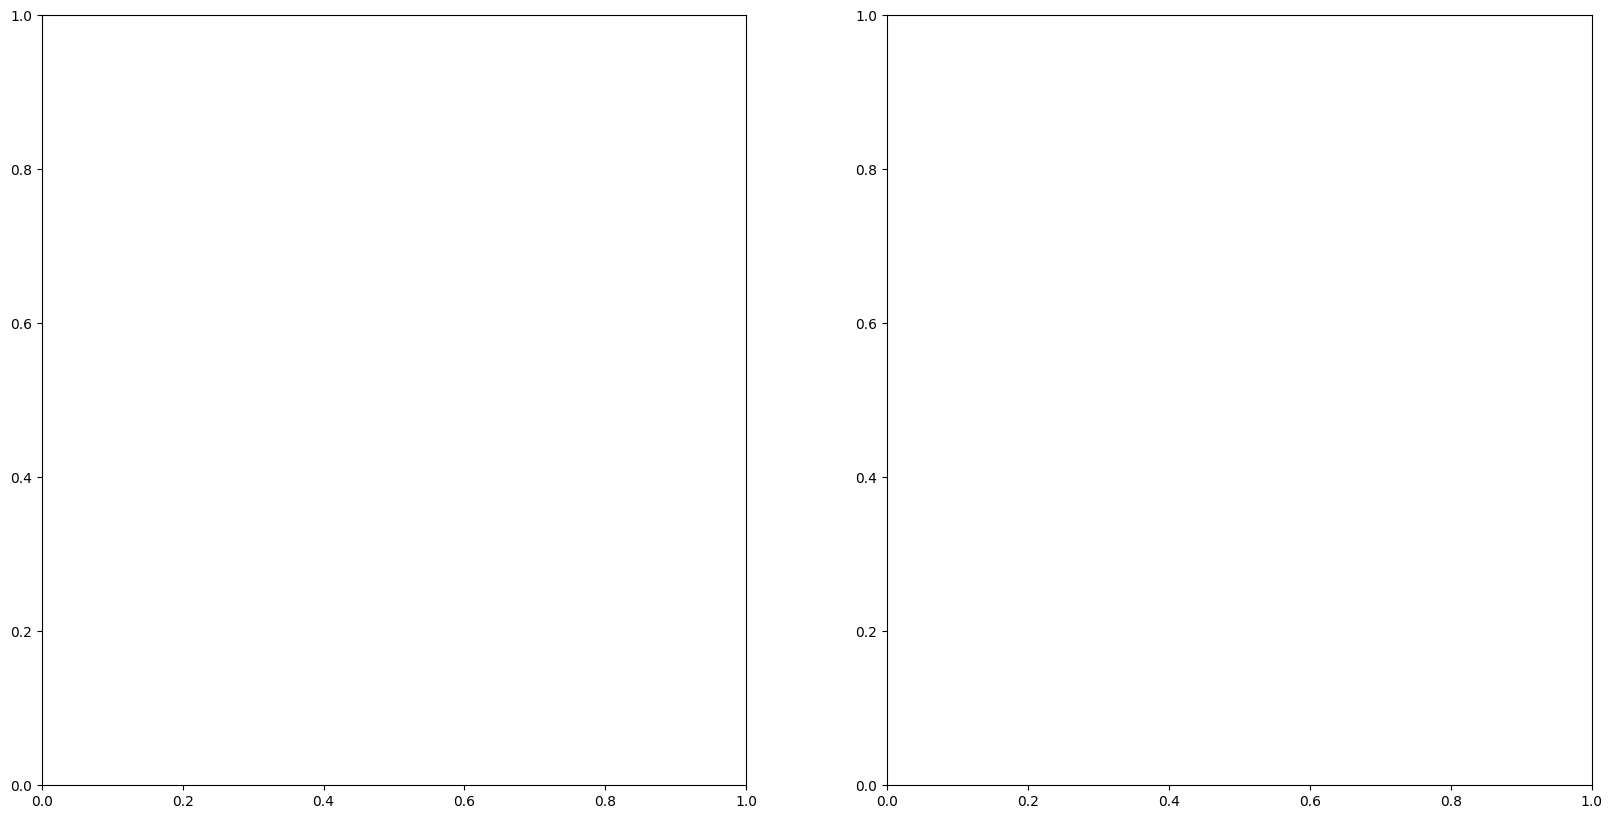

In [219]:
# Display wordcloud for each topic
wordcloud_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=30)

In [220]:
# Compare to original categories/labels
nmf_categories_counter = compare_to_og_categories(nmf_W_text_matrix, 'NMF', combined)


Topic 0:
tesla: 97
toyota: 79

Topic 1:
tesla: 3
toyota: 21


In [221]:
# Create confusion matrix by assuming majority category of each topic is "true label"
category_confusion_matrix(nmf_categories_counter, 'NMF', combined)

NameError: name 'sns' is not defined

<Figure size 600x400 with 0 Axes>

#### LSA/Truncated SVD

In [222]:
# Fit LSA/TruncatedSVD model
svd_text_model = TruncatedSVD(n_components = 2, random_state=42)
svd_W_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
svd_H_text_matrix = svd_text_model.components_

In [223]:
# Display top words for each topic
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  electric (0.97)
  new (0.84)
  chairman (0.83)
  shareholders (0.80)
  vehicle (0.79)

Topic 01
  shareholders (7.15)
  chairman (6.63)
  toyoda (5.56)
  vote (4.87)
  akio (4.32)


NameError: name 'WordCloud' is not defined

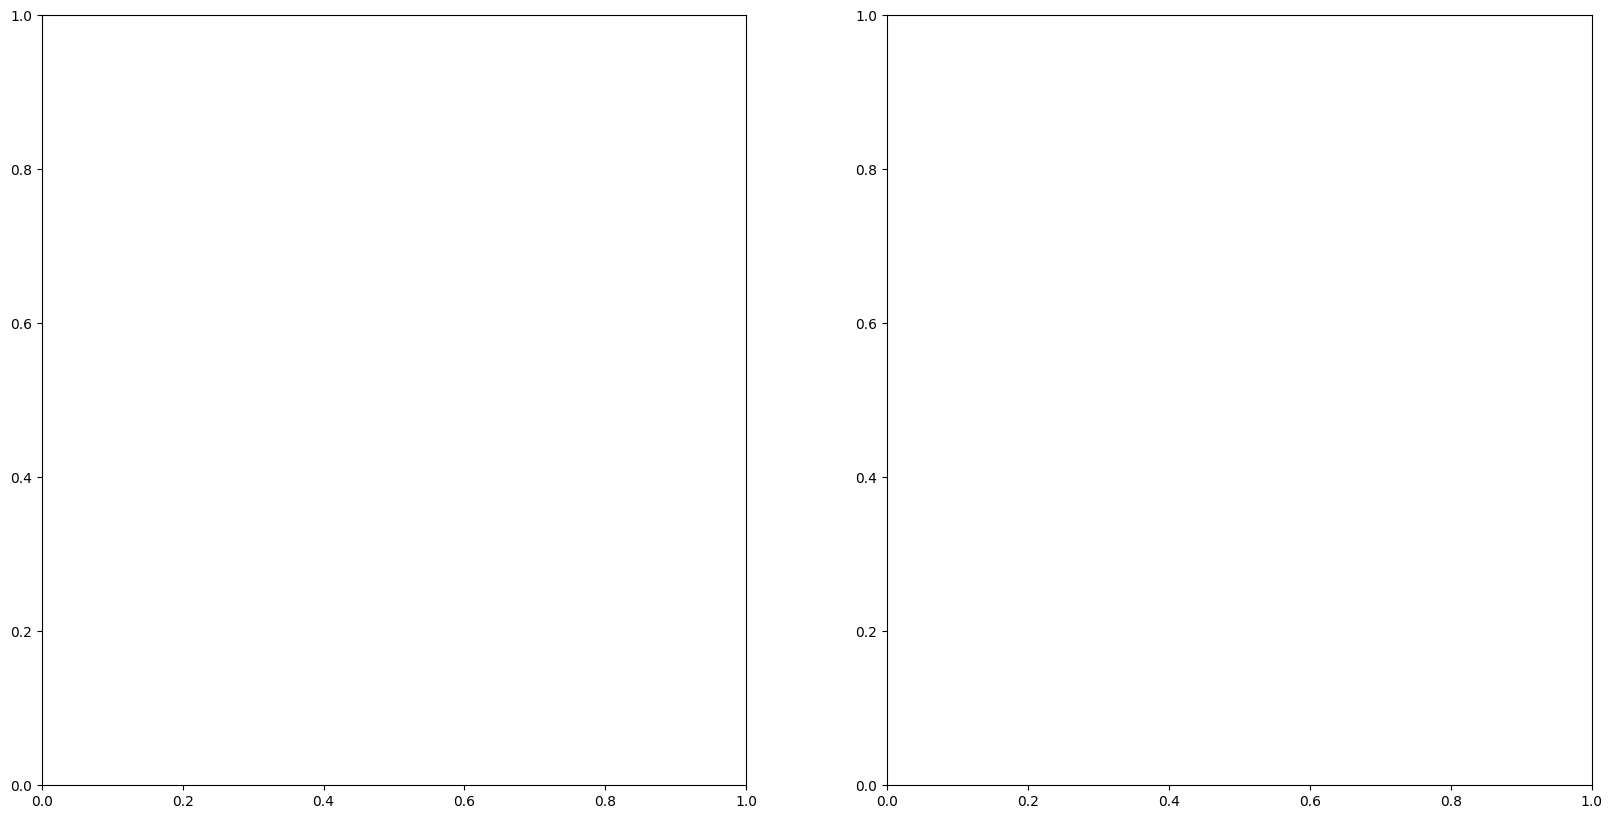

In [224]:
# Display wordcloud for each topic
wordcloud_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=30)

In [225]:
# Compare to original categories/labels
svd_categories_counter = compare_to_og_categories(svd_W_text_matrix, 'LSA/TruncSVD', combined)


Topic 0:
tesla: 98
toyota: 89

Topic 1:
tesla: 2
toyota: 11


In [226]:
# Create confusion matrix by assuming majority category of each topic is "true label"
category_confusion_matrix(svd_categories_counter, 'LSA/TruncSVD', combined)

NameError: name 'sns' is not defined

<Figure size 600x400 with 0 Axes>

#### LDA

In [227]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components = 2, random_state=42)
lda_W_text_matrix = lda_text_model.fit_transform(count_text_vectors)
lda_H_text_matrix = lda_text_model.components_

In [228]:
# Display top words for each topic
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  new (1.38)
  model (1.36)
  china (0.95)
  motor (0.86)
  vehicle (0.78)

Topic 01
  car (1.27)
  electric (1.22)
  elon (1.12)
  ev (1.05)
  musk (0.99)


NameError: name 'WordCloud' is not defined

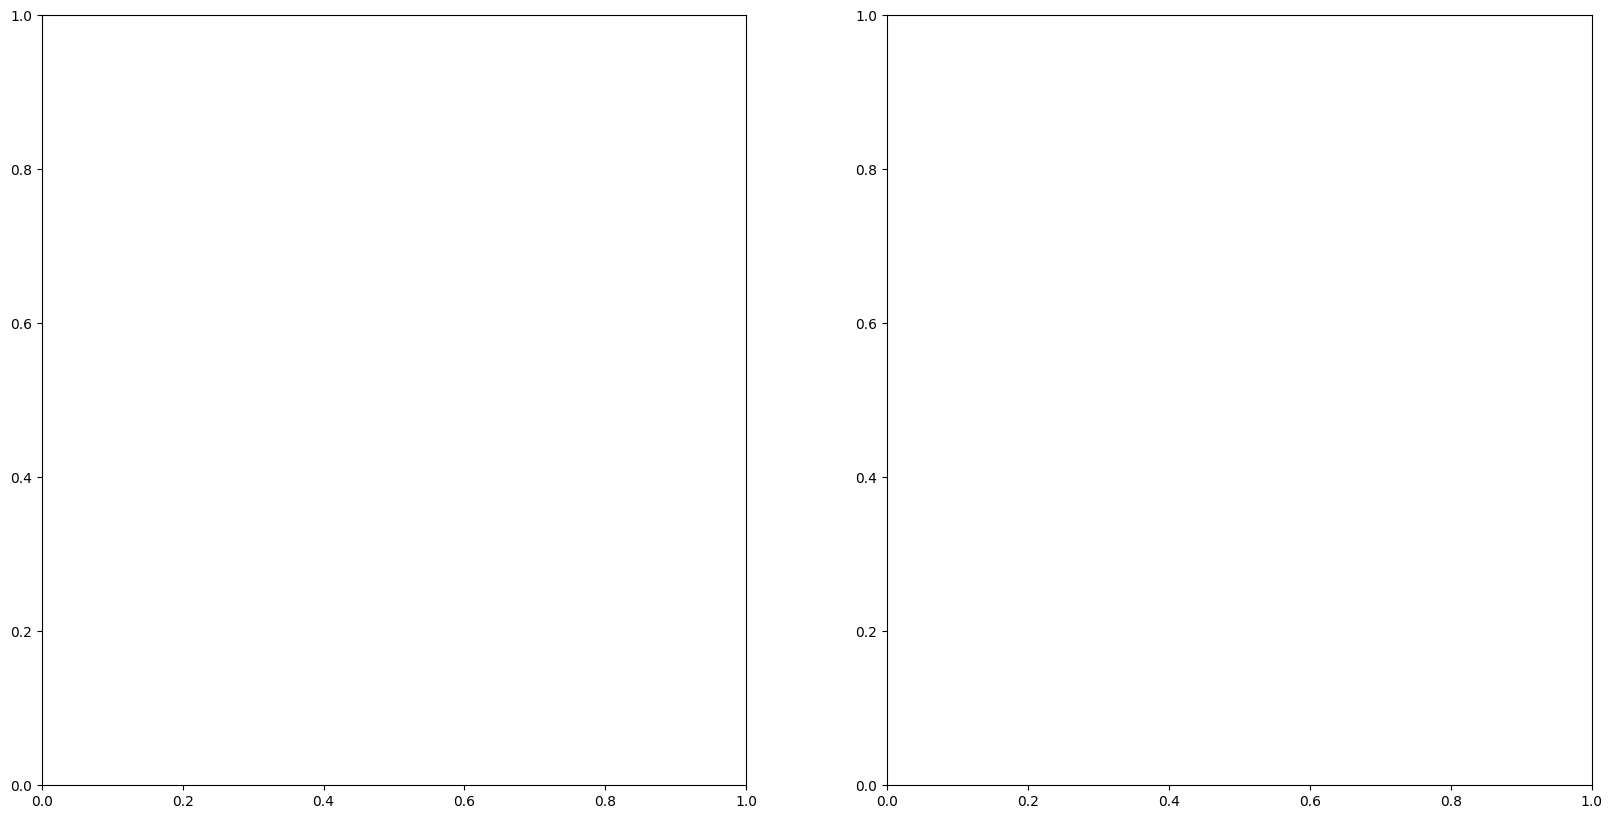

In [229]:
# Display wordcloud for each topic
wordcloud_topics(lda_text_model, count_text_vectorizer.get_feature_names_out(), no_top_words=30)

In [230]:
# Compare to original categories/labels
lda_categories_counter = compare_to_og_categories(lda_W_text_matrix, 'LDA', combined)


Topic 0:
tesla: 48
toyota: 53

Topic 1:
tesla: 52
toyota: 47


In [231]:
# Create confusion matrix by assuming majority category of each topic is "true label"
category_confusion_matrix(lda_categories_counter, 'LDA', combined)

NameError: name 'sns' is not defined

<Figure size 600x400 with 0 Axes>

In [232]:
# pyLDAvis display visual
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

### Try LDA with Identifying the Optimal Num of Topics


In [233]:
lda_text_model_n = []
perplexities = []
for n in tqdm(range(2, 15)):
    lda_model = LatentDirichletAllocation(n_components=n, random_state=42)
    lda_model.fit_transform(count_text_vectors)
    lda_perplexity = lda_model.perplexity(tfidf_text_vectors)
    lda_text_model_n.append((n, lda_model, lda_perplexity))
    perplexities.append(lda_perplexity)

  0%|          | 0/13 [00:00<?, ?it/s]

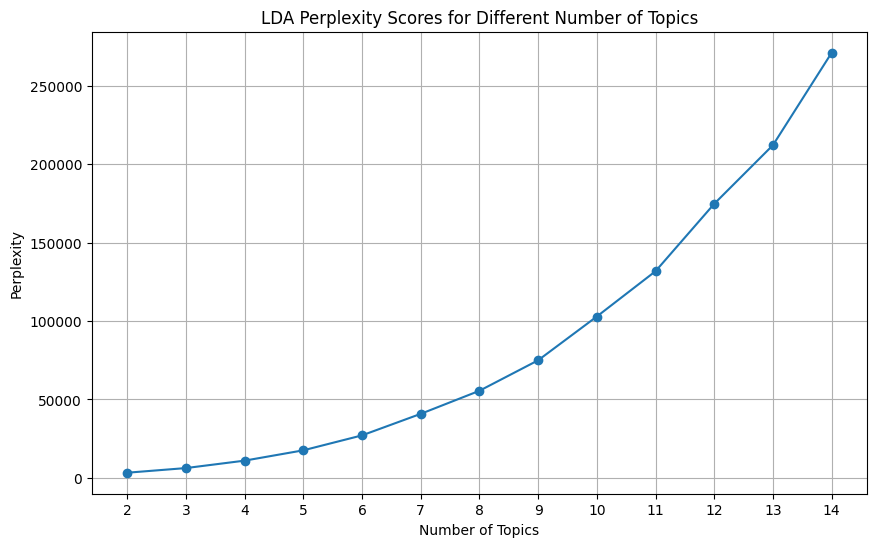

In [234]:
# Plotting the perplexity
plt.figure(figsize=(10, 6))
plt.plot(range(2, 15), perplexities, marker='o')
plt.title('LDA Perplexity Scores for Different Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(range(2, 15))
plt.grid(True)
plt.show()

In [235]:
# Find the model with the lowest perplexity
best_n, best_lda_model, best_perplexity = min(lda_text_model_n, key=lambda x: x[2])
print(f'Optimal number of topics: {best_n}, Perplexity: {best_perplexity}')

Optimal number of topics: 2, Perplexity: 3283.3449938469553


Result: Based on this simple LDA analysis, it does seem like 2 components is optimal as it results in the lowest perplexity for LDA topic modeling. Thus, we will not try going back and changing the number of components in the 3 aforementioned topic models.